In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff6_old as ds
from copy import copy as dup
from scipy.integrate import odeint

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
# Message
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
#Nstar = .55/(2*np.pi)
print ('Nstar', Nstar)
# Number of iterations to calculate Nliq from Ntot
niter = 1

Nstar 0.1432394487827058


In [4]:
# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth

print ('max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec')
print ('min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec')

Estgrowthrate = deprate*(2*sigmastepmax-sigma0)/2
print ('estimated growth rate =', Estgrowthrate*umpersec_over_mlyperus, 'um/sec')
Esttau = 1/Estgrowthrate
print ('estimated tau =', Esttau, 'us')
nt = 101
deltat_0d = Esttau/nt
print ('dt =', deltat_0d, 'us')
deprate_times_deltaT = deprate * deltat_0d


max growth rate = 9.8 um/sec
min growth rate = 0.49000000000000044 um/sec
estimated growth rate = 5.1450000000000005 um/sec
estimated tau = 58.30903790087463 us
dt = 0.5773172069393527 us


<IPython.core.display.Javascript object>


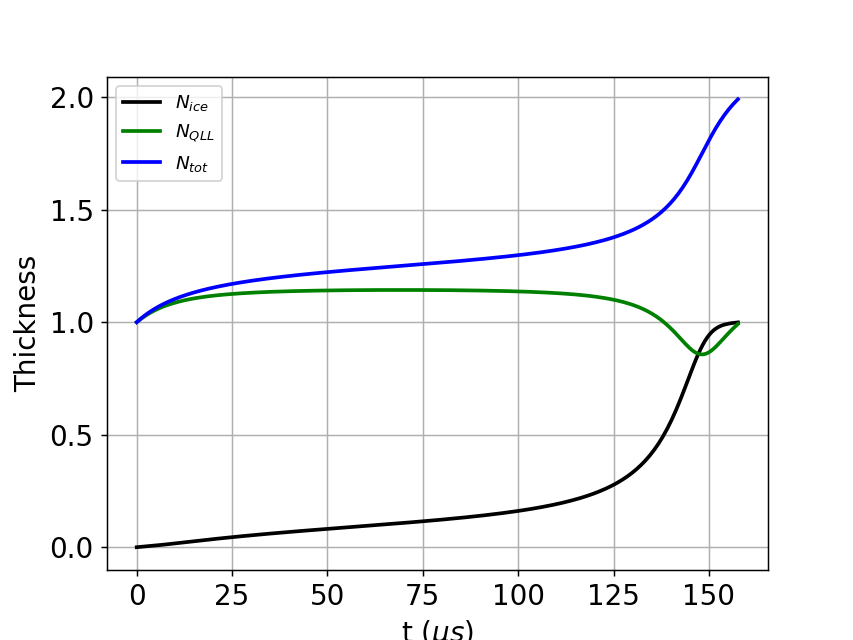

number of steps 273
tau 157.6075974944431
last Nice 0.9991066903797241


In [5]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, Nbar]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltat_0d]

# Initialize the keeper arrays
tkeep_0d = [t0]
ykeep_0d = [y0]
tlast = dup(t0)

# Call the ODE solver
counter = 0
layer = 0
updatingFliq = True
layermax_0d = 1.0
while True:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat_0d
    Fliqlast, Ntotlast = dup(ylast)
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter)
        ylast[0] = dup(Fliqlast)
    Nicelast = Ntotlast - Fliqlast

    # See whether to break
    if Nicelast > layermax_0d:
        break

    # Stuff into keeper arrays
    counter += 1
    ykeep_0d.append(ylast)
    tkeep_0d.append(tlast)
    
# Convert results to a numpy array
ykeep_0darr = np.array(ykeep_0d, np.float64)
tkeep_0darr = np.array(tkeep_0d, np.float64)

# Pack into separate arrays
Fliq = dup(ykeep_0darr[:,0])
Ntot = dup(ykeep_0darr[:,1])
Nice = Ntot-Fliq

# Save separate copies
Fliq0 = dup(Fliq)
Nice0 = dup(Nice)
Ntot0 = dup(Ntot)

# Plot results
fignum +=1
plt.figure(fignum)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0d,Nice,lw=linewidth,color='k')
plt.plot(tkeep_0d,Fliq,lw=linewidth,color='g')
plt.plot(tkeep_0d,Ntot,lw=linewidth,color='b')
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Thickness',fontsize=fontsize)
plt.legend([r'$N_{ice}$',r'$N_{QLL}$',r'$N_{tot}$'],loc='upper left')
plt.grid('on')

# Growth statistics
# delta_Ntot_0d = Ntotlast0-Ntotlast_start
# growthrate_0d_mlyperus = delta_Ntot_0d/tlast # monolayer/us
# growthrate_0d = growthrate_0d_mlyperus*umpersec_over_mlyperus # um/sec
# print  "0-D Modeled growth rate, um/s", growthrate_0d
# print  "0-D Modeled growth rate, ml/us", growthrate_0d_mlyperus
# alpha_0d = growthrate_0d/nu_kin/sigmastepmax
# print  "0-D Modeled alpha", alpha_0d
print ("number of steps", counter)
tau = dup(tkeep_0darr[-1])
print ("tau", tau)
print ('last Nice', Nice[-1])

In [6]:
# Parameters

# Spatial dependence
nx = counter+1
print ('nx =', nx)
xmax = 25.
w = xmax
print ('w=',w)
x = np.linspace(0, xmax, nx)
deltaX = x[1]-x[0]
sigmastep = np.ones(len(x))*sigmastepmax

# Number of time steps
nt_onecycle = 100
nt_onecycle = 1000

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond
#D = 1e-20 # micrometers^2/microsecond
print ('D=',D)

# Time step constraints for the 1-d run
dtmaxtimefactor = 2
dtmax = deltaX**2/D; print ('dtmax', dtmax)

# Actual time step for 1-d run
deltat_1d = tau/nt_onecycle; 
print ('dt', deltat_1d)
print ('Steps for 1 cycle', tau/deltat_1d)

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Formatting
stitle0 = r'$D=0, w=3 \ \mu m$'
stitle2 = r'$D=0.0002 \ \mu m^2/ \mu s, w=2 \ \mu m$'
stitle3 = r'$D=0.0002 \ \mu m^2/ \mu s, w=3 \ \mu m$'

nx = 274
w= 25.0
D= 0.0002
dtmax 41.92998698493203
dt 0.15760759749444309
Steps for 1 cycle 1000.0000000000001


In [7]:
# This is the 1-d run over one cycle

def propagate(nt,fignum=1,everythisstep=0,trajflag=True):

    # Flag for explicit updating Fliq(Ntot) every step
    updatingFliq = True

    # Bundle parameters for ODE solver
    params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

    # Initial conditions for ODE solver
    y0 = list((Fliq0,Ntot0))
    ylast = dup(y0)

    # Time steps
    t0 = 0.0
    tlast = dup(t0)
    ttot = 0.0
    tinterval = [t0, deltat_1d]

    # Initialize the keeper arrays
    tkeep = [dup(t0)]
    Nicekeep = [dup(Nice0)]
    Ntotkeep = [dup(Ntot0)]
    Fliqkeep = [dup(Fliq0)]

    # Graphics
    if everythisstep != 0:
        plt.figure(fignum)

    # Call the ODE solver
    lastlayer = 0
    lastdiff = 0
    for i in range(0,nt+1):

        # Make some local copies, with possible updates to Fliq
        Fliq, Ntot = ylast
        if updatingFliq:
            Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
            ylast[0] = Fliq
        Nice = Ntot - Fliq

        # Graph
        if everythisstep != 0:
            if np.mod(i,everythisstep)==0:
                plt.plot(x,Nice,lw=linewidth,color='k')
                plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
                plt.ylabel(r'$N_{ice}$',fontsize=fontsize)
                plt.grid('on')
                print ('counter', i)

        # Integrate up to next time step
        y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
        ylast = np.reshape(y[1],(2,nx))
        tlast += deltat_1d
        ttot += deltat_1d

        # Stuff into keeper arrays if requested
        if trajflag:
            Nicekeep.append(Nice)
            Ntotkeep.append(Ntot)
            Fliqkeep.append(Fliq)
            tkeep.append(ttot)
            
    return Fliqkeep, Nicekeep, Ntotkeep, tkeep


<IPython.core.display.Javascript object>


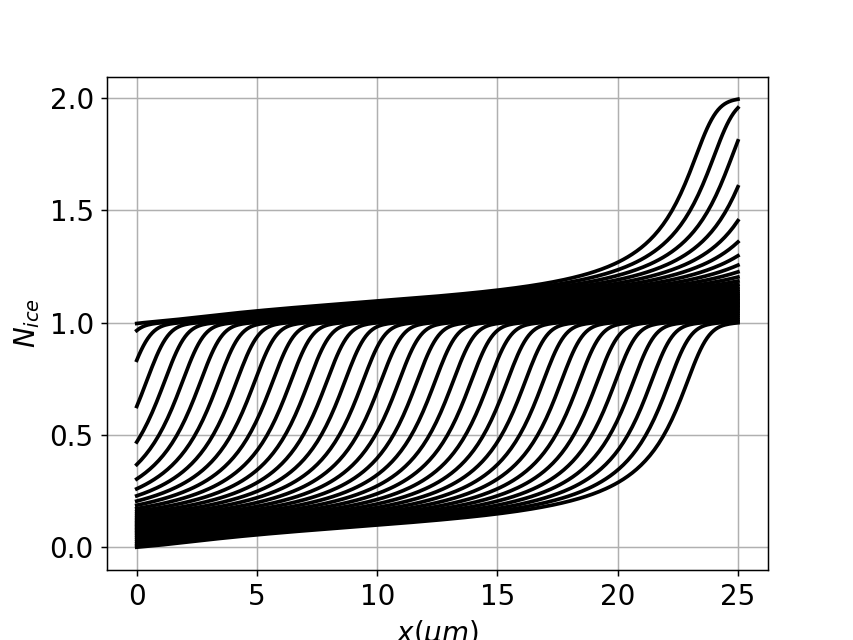

counter 0
from f1d:  0.014095890410958909 0.01566210045662101
from f1d:  0.0140958901942205 0.01566210021580056
from f1d:  0.014095889977482087 0.015662099974980102
from f1d:  0.014093722619964498 0.015659691988306784
from f1d:  0.014093722619962371 0.01565969198830442
from f1d:  0.014091555315664384 0.015657284437074117
from f1d:  0.014091555315660153 0.015657284437069423
from f1d:  0.014089388064854503 0.01565487732123786
from f1d:  0.014089388064850243 0.015654877321233142
from f1d:  0.014067718559367084 0.015630830100816763
from f1d:  0.014067718559148911 0.015630830100577173
from f1d:  0.014046054703140241 0.015606826373299762
from f1d:  0.014046054703168604 0.015606826373326176
from f1d:  0.01402439676799339 0.01558286609714058
from f1d:  0.014024396767820649 0.015582866096948499
from f1d:  0.01400274502176725 0.015558949228683864
from f1d:  0.01400274502159616 0.015558949228493574
from f1d:  0.013786625423335122 0.015322158347450232
from f1d:  0.013786625350907125 0.015322158266

from f1d:  0.0018741653091191575 0.003693662590864763
from f1d:  0.0018741652849356772 0.0036936625629917503
from f1d:  0.001874165260752199 0.0036936625351187405
from f1d:  0.0018739234454330908 0.0036933838234527905
from f1d:  0.0018739234454321087 0.0036933838234513446
from f1d:  0.0018736816690512641 0.003693105148677831
from f1d:  0.0018736816690492946 0.003693105148674938
from f1d:  0.001873439931598148 0.0036928265107862624
from f1d:  0.0018734399315961808 0.003692826510783374
from f1d:  0.0018710246966335761 0.003690042159329502
from f1d:  0.001871024696552174 0.003690042159209858
from f1d:  0.0018686133460522134 0.0036872614892101414
from f1d:  0.001868613346136958 0.003687261489334957
from f1d:  0.0018662058728115972 0.003684484495043186
from f1d:  0.0018662058728146566 0.003684484495047859
from f1d:  0.0018638022690469483 0.0036817111702220433
from f1d:  0.001863802269050003 0.0036817111702267123
from f1d:  0.0018399774097502134 0.003654178402634758
from f1d:  0.001839977411

from f1d:  0.0008160678485076538 0.002374798669357253
from f1d:  0.0008151933796891991 0.002373604675321931
from f1d:  0.0008151933797065141 0.0023736046753565694
from f1d:  0.0008143200110991114 0.0023724119779261923
from f1d:  0.000814320011099621 0.002372411977927285
from f1d:  0.000813447740911463 0.0023712205754033485
from f1d:  0.0008134477409119736 0.0023712205754044453
from f1d:  0.0008047850637233816 0.0023593774052332477
from f1d:  0.0008047850639603477 0.0023593774057412286
from f1d:  0.0008084957333417567 0.002364451405580778
from f1d:  0.0008084957246867759 0.0023644513937466772
from f1d:  0.0008084957160317934 0.002364451381912573
from f1d:  0.0008084091716342711 0.002364333047253018
from f1d:  0.0008084091716340739 0.0023643330472526256
from f1d:  0.0008083226381011094 0.0023642147254300445
from f1d:  0.0008083226381007078 0.0023642147254292396
from f1d:  0.0008082361154303518 0.0023640964164415978
from f1d:  0.0008082361154299504 0.002364096416440793
from f1d:  0.000807

from f1d:  0.0004017564345965949 0.001789347021962507
from f1d:  0.0004017564305222734 0.0017893470161226663
from f1d:  0.000401756426447952 0.0017893470102828257
from f1d:  0.0004017156852000777 0.001789288614876879
from f1d:  0.0004017156852000217 0.001789288614876736
from f1d:  0.0004016749478700398 0.0017892302254348914
from f1d:  0.00040167494786993 0.0017892302254346056
from f1d:  0.0004016342144572284 0.0017891718419561357
from f1d:  0.0004016342144571185 0.0017891718419558499
from f1d:  0.00040122709566338757 0.0017885883350405875
from f1d:  0.00040122709565883094 0.0017885883350287882
from f1d:  0.0004008203679744737 0.0017880054237850052
from f1d:  0.00040082036797915125 0.001788005423797171
from f1d:  0.0004004140308663355 0.0017874231076822392
from f1d:  0.00040041403086644615 0.0017874231076825673
from f1d:  0.0004000080837689093 0.0017868413861047408
from f1d:  0.00040000808376901986 0.0017868413861050689
from f1d:  0.00039596994281333096 0.0017810567427327326
from f1d:  

from f1d:  0.0003139839906971034 0.0016649611665807778
from f1d:  0.0003136566316038783 0.0016645057022453172
from f1d:  0.00031365663160085153 0.0016645057022368892
from f1d:  0.00031332955205182336 0.001664050715403067
from f1d:  0.0003133295520549239 0.001664050715411741
from f1d:  0.000313002751671485 0.0016635962056933673
from f1d:  0.0003130027516715522 0.0016635962056935946
from f1d:  0.00031267623006285056 0.001663142172669411
from f1d:  0.00031267623006291735 0.0016631421726696345
from f1d:  0.00030942626162537145 0.001658627970104736
from f1d:  0.0003094262616577844 0.001658627970215389
from f1d:  0.0003108201028939673 0.0016605618613248193
from f1d:  0.00031082009964595133 0.0016605618568139493
from f1d:  0.0003108200963979347 0.0016605618523030752
from f1d:  0.0003107876176333228 0.0016605167459999765
from f1d:  0.00031078761763328515 0.0016605167459998725
from f1d:  0.00031075514163022314 0.0016604716444358785
from f1d:  0.0003107551416301501 0.0016604716444356743
from f1d

from f1d:  5.646949322994535e-05 0.0013860300509194315
from f1d:  5.646949322995222e-05 0.001386030050919512
from f1d:  5.629515760004697e-05 0.001385948579779801
from f1d:  5.6295157600053825e-05 0.0013859485797798814
from f1d:  5.455394228471947e-05 0.0013851477369358105
from f1d:  5.4553942287521554e-05 0.001385147736971835
from f1d:  5.530215083780853e-05 0.0013854879129809026
from f1d:  5.530214909687223e-05 0.0013854879121818313
from f1d:  5.530214735593566e-05 0.00138548791138276
from f1d:  5.5284738178320344e-05 0.001385479921877186
from f1d:  5.528473817831267e-05 0.0013854799218771666
from f1d:  5.526732938647836e-05 0.001385471934891567
from f1d:  5.526732938646209e-05 0.0013854719348915477
from f1d:  5.524992098027878e-05 0.0013854639504258563
from f1d:  5.524992098026253e-05 0.0013854639504258372
from f1d:  5.5075858102395744e-05 0.0013853842443525821
from f1d:  5.507585810170401e-05 0.0013853842443514411
from f1d:  5.490183365009279e-05 0.0013853047902042282
from f1d:  5.

from f1d:  -7.158697715959485e-05 0.0013939753961548637
from f1d:  -7.15869771596026e-05 0.0013939753961549441
from f1d:  -7.176522046496784e-05 0.0013940792607387157
from f1d:  -7.176522046497584e-05 0.0013940792607388002
from f1d:  -7.355045898691663e-05 0.001395132118224326
from f1d:  -7.355045899081108e-05 0.0013951321182624722
from f1d:  -7.278209809438142e-05 0.001394674761273074
from f1d:  -7.278209987996963e-05 0.0013946747623277387
from f1d:  -7.278210166555793e-05 0.0013946747633823997
from f1d:  -7.279995780806182e-05 0.001394685311316875
from f1d:  -7.279995780807145e-05 0.001394685311316894
from f1d:  -7.281781446432297e-05 0.0013946958618373763
from f1d:  -7.281781446434104e-05 0.0013946958618374185
from f1d:  -7.283567163447956e-05 0.0013947064149440168
from f1d:  -7.283567163449761e-05 0.001394706414944059
from f1d:  -7.301427162788157e-05 0.0013948120882610368
from f1d:  -7.301427162863364e-05 0.0013948120882626084
from f1d:  -7.319292315699998e-05 0.001394918020277064

from f1d:  -0.00021892531087587427 0.001538175115644162
from f1d:  -0.00021892531340983915 0.0015381751188200804
from f1d:  -0.00021892531594380413 0.001538175121995999
from f1d:  -0.00021895065646428772 0.0015382068829516444
from f1d:  -0.00021895065646430803 0.001538206882951706
from f1d:  -0.00021897599874851325 0.0015382386475946063
from f1d:  -0.0002189759987485557 0.0015382386475947297
from f1d:  -0.0002190013427967609 0.0015382704159252359
from f1d:  -0.00021900134279680277 0.0015382704159253551
from f1d:  -0.00021925488035242372 0.0015385883020997565
from f1d:  -0.00021925488035423238 0.0015385883021051263
from f1d:  -0.0002195085945911906 0.0015389065573367243
from f1d:  -0.0002195085945894241 0.0015389065573315356
from f1d:  -0.00021976248575466186 0.001539225181864133
from f1d:  -0.0002197624857546974 0.0015392251818642756
from f1d:  -0.00022001655410300663 0.0015395441759643725
from f1d:  -0.00022001655410304217 0.0015395441759645148
from f1d:  -0.00022256703851831572 0.001

from f1d:  -0.0008079741392347834 0.0023637382657755164
from f1d:  -0.0008088398981406347 0.0023649227784722613
from f1d:  -0.0008088398981572955 0.00236492277850566
from f1d:  -0.0008097067456422876 0.002366108577537354
from f1d:  -0.0008097067456261656 0.0023661085775051292
from f1d:  -0.0008105746833949181 0.002367295664417717
from f1d:  -0.0008105746833954203 0.0023672956644187905
from f1d:  -0.0008114437132252259 0.0023684840408999
from f1d:  -0.0008114437132257281 0.002368484040900973
from f1d:  -0.0008201944643564464 0.0023804390974211972
from f1d:  -0.0008201944646041945 0.0023804390979490697
from f1d:  -0.0008164143781150831 0.0023752716247746404
from f1d:  -0.0008164143868734285 0.0023752716367387012
from f1d:  -0.0008164143956317744 0.002375271648702762
from f1d:  -0.0008165019845824964 0.0023753912957413113
from f1d:  -0.0008165019845827013 0.0023753912957417233
from f1d:  -0.0008165895845743457 0.002375510955788675
from f1d:  -0.0008165895845747492 0.00237551095578948
from

from f1d:  -0.0015366654838700412 0.0032962328353528035
from f1d:  -0.0015366654838720529 0.0032962328353561177
from f1d:  -0.0015385565659981571 0.0032985115051526763
from f1d:  -0.0015385565660001853 0.0032985115051560143
from f1d:  -0.001557627358071092 0.003321456641461192
from f1d:  -0.0015576273590721893 0.003321456643101251
from f1d:  -0.0015493787257231909 0.003311528341945043
from f1d:  -0.0015493787448140012 0.0033115283649101023
from f1d:  -0.0015493787639048102 0.003311528387875159
from f1d:  -0.0015495696866162142 0.0033117580528818236
from f1d:  -0.0015495696866169033 0.0033117580528829096
from f1d:  -0.0015497606385655558 0.0033119877468227627
from f1d:  -0.001549760638566936 0.0033119877468249293
from f1d:  -0.0015499516197590082 0.0033122174697036307
from f1d:  -0.0015499516197603905 0.0033122174697058017
from f1d:  -0.0015518630412170698 0.003314516291044749
from f1d:  -0.001551863041274981 0.0033145162911357873
from f1d:  -0.0015537773932324944 0.003316818011591299
f

from f1d:  -0.002584111834585562 0.004482194960653592
from f1d:  -0.0025841118345891535 0.004482194960658331
from f1d:  -0.0025877288025131064 0.004486082432289362
from f1d:  -0.0025877288026639814 0.004486082432488362
from f1d:  -0.002591352083707489 0.004489975527322823
from f1d:  -0.002591352083563152 0.004489975527132792
from f1d:  -0.0025949816902602475 0.004493874254816901
from f1d:  -0.002594981690266249 0.00449387425482503
from f1d:  -0.002598617635806964 0.0044977786258534255
from f1d:  -0.0025986176358130005 0.004497778625861595
from f1d:  -0.0026353286147057986 0.004537134997843075
from f1d:  -0.0026353286176945307 0.004537135001870391
from f1d:  -0.0026194315414623495 0.004520085486394342
from f1d:  -0.0026194315782171367 0.004520085525789855
from f1d:  -0.002619431614971923 0.0045200855651853665
from f1d:  -0.0026197991950117194 0.004520479548964829
from f1d:  -0.00261979919501356 0.004520479548967242
from f1d:  -0.0026201668393332133 0.0045208735898828465
from f1d:  -0.00

from f1d:  -0.003785161764974566 0.005720437287198938
from f1d:  -0.00378516176527174 0.005720437287547102
from f1d:  -0.0037909640805388113 0.005726216965708607
from f1d:  -0.003790964080255077 0.005726216965376545
from f1d:  -0.003796777301138646 0.005732005900559786
from f1d:  -0.0037967773011509808 0.005732005900574414
from f1d:  -0.003802601451054529 0.005737804111651765
from f1d:  -0.0038026014510669317 0.005737804111666456
from f1d:  -0.0038614491589099853 0.005796300496564737
from f1d:  -0.0038614491650389745 0.005796300503788497
from f1d:  -0.00383594377527699 0.005770933985202975
from f1d:  -0.003835943834199995 0.005770934043763537
from f1d:  -0.003835943893122998 0.005770934102324095
from f1d:  -0.00383653317856484 0.005771519754914774
from f1d:  -0.003836533178568467 0.005771519754919005
from f1d:  -0.003837122574878244 0.005772105501533321
from f1d:  -0.0038371225748854974 0.005772105501541785
from f1d:  -0.0038377120820902804 0.005772691342202793
from f1d:  -0.0038377120

from f1d:  -0.016201164249393135 0.018249013130082124
from f1d:  -0.016203209345611064 0.01825186557918903
from f1d:  -0.016203209345576827 0.01825186557915728
from f1d:  -0.01622364049923943 0.01828041475898729
from f1d:  -0.01622364049772728 0.018280414757570383
from f1d:  -0.016244035217859738 0.01830900880251756
from f1d:  -0.01624403521895541 0.018309008803458607
from f1d:  -0.016264392917708252 0.018337647690462942
from f1d:  -0.016264392917324778 0.018337647690027443
from f1d:  -0.016284712997057315 0.018366331389580937
from f1d:  -0.01628471299667126 0.01836633138914218
from f1d:  -0.016485710934133264 0.018655626314929397
from f1d:  -0.016485710734044912 0.018655626085910374
from f1d:  -0.016399232925900006 0.01853005368775876
from f1d:  -0.016399233126630174 0.018530053977358844
from f1d:  -0.016399233327360326 0.018530054266958928
from f1d:  -0.01640124042032573 0.0185329504908563
from f1d:  -0.016401240420305937 0.01853295049083775
from f1d:  -0.01640324709558951 0.01853584

from f1d:  0.01436304594044376 0.029816460397446926
from f1d:  0.01413105519441056 0.029939153719283608
from f1d:  0.014131055742236474 0.02993915343702996
from f1d:  0.014131056290062347 0.02993915315477628
from f1d:  0.014136532724228976 0.029936330115066332
from f1d:  0.014136532724257514 0.029936330115248294
from f1d:  0.014142005509443487 0.029933506070105732
from f1d:  0.014142005509500712 0.029933506070469636
from f1d:  0.014147474645496065 0.02993068102089594
from f1d:  0.014147474645553515 0.029930681021259856
from f1d:  0.014201965246489175 0.0299023754469163
from f1d:  0.014201965249104831 0.02990237546211793
from f1d:  0.014256090688968215 0.029873970379287424
from f1d:  0.014256090687261976 0.02987397036428599
from f1d:  0.014309850754241106 0.029845466543858848
from f1d:  0.014309850755093853 0.029845466544021065
from f1d:  0.014363245267941879 0.029816864820235586
from f1d:  0.014363245268787007 0.02981686482038025
from f1d:  0.014877058559865501 0.029525642842565036
fro

<IPython.core.display.Javascript object>


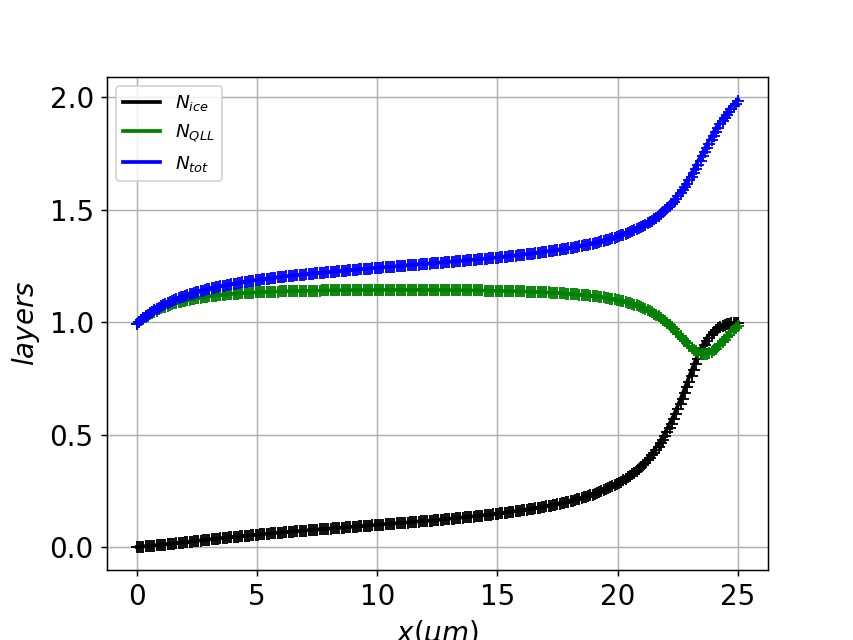

In [8]:
# Integrate over one cycle
fignum+=1; Fliqkeep, Nicekeep, Ntotkeep, tkeep = propagate(nt_onecycle, fignum, everythisstep=30)

# Checking: Plot first and last superimposed
fignum +=1
plt.figure(fignum)
plt.plot(\
         x, Nicekeep[0], 'k', \
         x, Fliqkeep[0], 'g', \
         x, Ntotkeep[0], 'b', \
         lw=linewidth)
plt.plot(\
         x, Nicekeep[-1]-1, 'k+', \
         x, Fliqkeep[-1], 'g+', \
         x, Ntotkeep[-1]-1, 'b+', \
         lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$layers$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend([r'$N_{ice}$',r'$N_{QLL}$',r'$N_{tot}$'],loc='upper left')
plt.grid('on')


In [9]:
Fliqkeep, Nicekeep, Ntotkeep, tkeep = propagate(nt_onecycle*5)

from f1d:  0.014095890410958909 0.01566210045662101
from f1d:  0.0140958901942205 0.01566210021580056
from f1d:  0.014095889977482087 0.015662099974980102
from f1d:  0.014093722619964498 0.015659691988306784
from f1d:  0.014093722619962371 0.01565969198830442
from f1d:  0.014091555315664384 0.015657284437074117
from f1d:  0.014091555315660153 0.015657284437069423
from f1d:  0.014089388064854503 0.01565487732123786
from f1d:  0.014089388064850243 0.015654877321233142
from f1d:  0.014067718559367084 0.015630830100816763
from f1d:  0.014067718559148911 0.015630830100577173
from f1d:  0.014046054703140241 0.015606826373299762
from f1d:  0.014046054703168604 0.015606826373326176
from f1d:  0.01402439676799339 0.01558286609714058
from f1d:  0.014024396767820649 0.015582866096948499
from f1d:  0.01400274502176725 0.015558949228683864
from f1d:  0.01400274502159616 0.015558949228493574
from f1d:  0.013786625423335122 0.015322158347450232
from f1d:  0.013786625350907125 0.015322158266639782
fro

from f1d:  0.011143436227145068 0.012632795196872224
from f1d:  0.011143436227119642 0.012632795196836608
from f1d:  0.01112440059407401 0.012614416878440234
from f1d:  0.011124400594049295 0.012614416878405369
from f1d:  0.01093548732643914 0.012432561588878958
from f1d:  0.010935487318141606 0.012432561576015995
from f1d:  0.01101639155072434 0.012510325047459725
from f1d:  0.011016391361993613 0.012510324865851394
from f1d:  0.011016391173262889 0.012510324684243065
from f1d:  0.011014503997818099 0.012508508775307688
from f1d:  0.011014503997806489 0.012508508775296788
from f1d:  0.011012617086061566 0.012506693215103205
from f1d:  0.011012617086038352 0.012506693215081416
from f1d:  0.011010730438026433 0.012504878003554681
from f1d:  0.011010730438003217 0.012504878003532892
from f1d:  0.010991878473955732 0.01248674505176756
from f1d:  0.010991878472982466 0.01248674505085202
from f1d:  0.010973052928723899 0.012468646893362429
from f1d:  0.01097305292967545 0.012468646894244874

from f1d:  0.006737018642214109 0.008525581577030136
from f1d:  0.006737018642239987 0.008525581577054837
from f1d:  0.006623301310911205 0.008420471448467904
from f1d:  0.006623301323287959 0.008420471460405856
from f1d:  0.006671923976214011 0.008465424306098916
from f1d:  0.006671923862651582 0.00846542420112474
from f1d:  0.006671923749089147 0.008465424096150557
from f1d:  0.0066707882341314395 0.008464374450049867
from f1d:  0.006670788234122913 0.008464374450041263
from f1d:  0.006669652937918871 0.00846332499543887
from f1d:  0.006669652937901803 0.008463324995421639
from f1d:  0.006668517860405313 0.008462275732267729
from f1d:  0.006668517860388263 0.008462275732250522
from f1d:  0.006657179106773795 0.008451793622029621
from f1d:  0.006657179106068578 0.00845179362131728
from f1d:  0.006645862180273111 0.008441330609078373
from f1d:  0.006645862181006441 0.008441330609817915
from f1d:  0.006634567047713873 0.008430886656799395
from f1d:  0.006634567047739482 0.00843088665682

from f1d:  0.005454066196414929 0.007330701082548029
from f1d:  0.005454066196402108 0.0073307010825344595
from f1d:  0.005453166839563853 0.007329854338019567
from f1d:  0.005453166839551042 0.007329854338006003
from f1d:  0.005444182878189267 0.007321395030238694
from f1d:  0.005444182877659623 0.007321395029677624
from f1d:  0.005435216357251801 0.007312950492906845
from f1d:  0.0054352163578048765 0.007312950493492585
from f1d:  0.005426267245528415 0.007304520698221626
from f1d:  0.005426267245549776 0.007304520698243941
from f1d:  0.0054173355063776565 0.007296105612665531
from f1d:  0.005417335506399047 0.00729610561268789
from f1d:  0.005328966069428512 0.007212756957994264
from f1d:  0.005328966079481421 0.0072127569685709525
from f1d:  0.005366747577496138 0.007248409363030725
from f1d:  0.005366747489248305 0.007248409279784994
from f1d:  0.005366747401000467 0.007248409196539256
from f1d:  0.005365865008366473 0.007247576811731881
from f1d:  0.005365865008360221 0.007247576

from f1d:  0.0020744716468624764 0.00392192268869489
from f1d:  0.0020717286827779046 0.003918831173808461
from f1d:  0.0020717286827817124 0.003918831173814059
from f1d:  0.0020689902468989867 0.003915743860131166
from f1d:  0.002068990246902792 0.003915743860136755
from f1d:  0.0020418529730316724 0.0038851002094918018
from f1d:  0.0020418529748013454 0.0038851002121035173
from f1d:  0.002053464025540143 0.0038982199934433385
from f1d:  0.0020534639984345774 0.0038982199628290956
from f1d:  0.0020534639713290113 0.0038982199322148514
from f1d:  0.002053192938017393 0.003897913810529907
from f1d:  0.0020531929380162247 0.003897913810528247
from f1d:  0.002052921949381422 0.0038976077303700335
from f1d:  0.002052921949379078 0.0038976077303666907
from f1d:  0.002052651005411076 0.003897301691726444
from f1d:  0.0020526510054087424 0.003897301691723122
from f1d:  0.0020499440205535976 0.0038942435873820696
from f1d:  0.0020499440204569835 0.003894243587244463
from f1d:  0.00204724149234

from f1d:  0.000957632052073957 0.002565428105753827
from f1d:  0.0009576320524205389 0.0025654281064434303
from f1d:  0.0009621939415985425 0.0025714813422435547
from f1d:  0.0009621939309563717 0.002571481328124642
from f1d:  0.0009621939203142011 0.00257148131400573
from f1d:  0.000962087505646309 0.0025713401327262333
from f1d:  0.0009620875056460345 0.0025713401327257194
from f1d:  0.0009619811051127962 0.0025711989673015663
from f1d:  0.0009619811051122449 0.002571198967300533
from f1d:  0.0009618747187110044 0.002571057817729042
from f1d:  0.0009618747187104535 0.0025710578177280093
from f1d:  0.0009608116314595002 0.002569647193478735
from f1d:  0.0009608116314366152 0.0025696471934358264
from f1d:  0.0009597499547289375 0.0025682381519897715
from f1d:  0.0009597499547526118 0.002568238152034274
from f1d:  0.0009586896862979493 0.002566830691382209
from f1d:  0.0009586896862986743 0.002566830691383655
from f1d:  0.0009576308237143959 0.0025654248093381093
from f1d:  0.000957630

from f1d:  0.0003779942662064528 0.0017553514094822145
from f1d:  0.0003779942623575828 0.0017553514039900513
from f1d:  0.0003779942585087136 0.0017553513984978918
from f1d:  0.00037795577162955444 0.001755296479763049
from f1d:  0.0003779557716295017 0.0017552964797629023
from f1d:  0.00037791728835054295 0.0017552415666574252
from f1d:  0.0003779172883504431 0.0017552415666571594
from f1d:  0.00037787880867112995 0.0017551866591803762
from f1d:  0.0003778788086710293 0.001755186659180106
from f1d:  0.0003774942097511844 0.0017546378938834578
from f1d:  0.00037749420974708 0.001754637893872624
from f1d:  0.000377109970226679 0.0017540896908335923
from f1d:  0.0003771099702308939 0.001754089690844773
from f1d:  0.00037672608961861247 0.0017535420495652793
from f1d:  0.0003767260896187128 0.0017535420495655878
from f1d:  0.0003763425674066476 0.0017529949695024995
from f1d:  0.00037634256740674826 0.0017529949695028082
from f1d:  0.0003725269469559501 0.0017475549190731562
from f1d:  0

from f1d:  0.00026207851713404187 0.001594092758727171
from f1d:  0.00026207851713398516 0.0015940927587270051
from f1d:  0.00026205000499996057 0.0015940547574647959
from f1d:  0.00026205000499990424 0.0015940547574646343
from f1d:  0.00026176500513912704 0.001593674973204831
from f1d:  0.0002617650051368324 0.0015936749731981904
from f1d:  0.00026148022592265127 0.0015932956038875168
from f1d:  0.0002614802259250003 0.0015932956038943618
from f1d:  0.00026119566705672093 0.0015929166492287786
from f1d:  0.0002611956670567709 0.0015929166492289633
from f1d:  0.0002609113282244003 0.0015925381088767547
from f1d:  0.00026091132822444937 0.0015925381088769358
from f1d:  0.0002580799744502412 0.0015887754213262878
from f1d:  0.0002580799744734291 0.0015887754214140989
from f1d:  0.00025929457771367743 0.001590387035349332
from f1d:  0.0002592945748838658 0.0015903870315895452
from f1d:  0.0002592945720540542 0.001590387027829759
from f1d:  0.00025926627503169866 0.0015903494320028844
from

from f1d:  6.224559388856609e-05 0.0013888638293465564
from f1d:  6.224559388854885e-05 0.001388863829346518
from f1d:  6.206988999514073e-05 0.0013887739980158816
from f1d:  6.206988999442732e-05 0.001388773998014575
from f1d:  6.189422956021196e-05 0.0013886844210095912
from f1d:  6.189422956093191e-05 0.0013886844210109746
from f1d:  6.171861246118392e-05 0.001388595098272303
from f1d:  6.17186124611911e-05 0.0013885950982723834
from f1d:  6.154303856824527e-05 0.0013885060297353208
from f1d:  6.154303856825237e-05 0.0013885060297354056
from f1d:  5.978964812595484e-05 0.0013876293116064074
from f1d:  5.978964812904931e-05 0.0013876293116429207
from f1d:  6.054304193548851e-05 0.0013880020965948163
from f1d:  6.054304018240278e-05 0.0013880020957198849
from f1d:  6.054303842931704e-05 0.001388002094844953
from f1d:  6.0525507783678475e-05 0.0013879933467223144
from f1d:  6.0525507783670554e-05 0.0013879933467222916
from f1d:  6.0507977561493e-05 0.0013879846011374101
from f1d:  6.05

KeyboardInterrupt: 

In [ ]:
Fliqkeeparr = np.array(Fliqkeep)
fignum +=1
plt.figure(fignum)
plt.plot(\
         tkeep, Fliqkeeparr[:,0], 'k', \
         lw=linewidth)
plt.grid('on')
stitle = stitle2
plt.title(stitle,fontsize=fontsize)
plt.xlabel(r'$t (\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL}$',fontsize=fontsize)

In [ ]:
Fliqkeeparr2 = Fliqkeeparr 

In [ ]:
# # This is graphing multiple runs

# fignum +=1
# plt.figure(fignum)
# plt.plot(\
#          tkeep, Fliqkeeparr0[:,0], 'k', \
#          tkeep, Fliqkeeparr3[:,0], 'g-o', \
#          tkeep, Fliqkeeparr2[:,0], 'b-+', \
#          lw=linewidth)
# plt.grid('on')
# plt.legend([stitle0,stitle3,stitle2],fontsize=fontsize,bbox_to_anchor=(.7, 1.11))
# plt.ylim([.85,1.2])
# plt.xlabel(r'$t (\mu s$)',fontsize=fontsize)
# plt.ylabel(r'$N_{QLL}$',fontsize=fontsize)

In [ ]:
# # Saving these results to file
# print Nice[0]
# if Nice[0] > 100000:
#     Nice -= 100000
# if Save_new_file:
#     print "saving to", nextfile
#     np.savez_compressed(nextfile, Nice=Nice, Fliq=Fliq, 
#                         x=x, t=ttot,
#                         Nbar=Nbar, Nstar=Nstar,
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


In [ ]:
# if trajflag:
#     print "saving to", trajfile
#     np.savez_compressed(trajfile, Nice=Nicekeep, Fliq=Fliqkeep,
#                         x=x, t=tkeep, 
#                         Nbar=Nbar, Nstar=Nstar,
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle)


In [ ]:
# if traj0flag:
#     print "saving to", traj0file
#     np.savez_compressed(traj0file, ykeep_0Darr=ykeep_0Darr,
#                         x=x, tkeep_0D=tkeep_0D,  
#                         sigma0=sigma0, c_r=c_r, D=D, L=L, 
#                         nu_kin=nu_kin, nu_kin_ml=nu_kin_ml, 
#                         sigmastepmax=sigmastepmax, sigmastepstyle=sigmastepstyle,
#                         dtmaxtimefactor = dtmaxtimefactor,
#                         deltaT = deltaT)
